In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [6]:
df = pd.read_csv('options/aapl_option_chain.csv', encoding='utf-8')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112394 entries, 0 to 112393
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        112394 non-null  object 
 1   act_symbol  112394 non-null  object 
 2   expiration  112394 non-null  object 
 3   strike      112394 non-null  float64
 4   call_put    112394 non-null  object 
 5   bid         112394 non-null  float64
 6   ask         112394 non-null  float64
 7   vol         112394 non-null  float64
 8   delta       112394 non-null  float64
 9   gamma       112394 non-null  float64
 10  theta       112394 non-null  float64
 11  vega        112394 non-null  float64
 12  rho         112394 non-null  float64
dtypes: float64(9), object(4)
memory usage: 11.1+ MB


In [8]:
len(df[df['date'] == '2019-02-09'])

66

In [9]:
df.head(67)

,date,act_symbol,expiration,strike,call_put,bid,ask,vol,delta,gamma,theta,vega,rho
0,2019-02-09,AAPL,2019-02-22,145.0,Call,25.30,26.05,0.4236,0.9773,0.0038,-0.0371,0.0180,0.0540
1,2019-02-09,AAPL,2019-02-22,145.0,Put,0.06,0.08,0.3886,-0.0149,0.0029,-0.0172,0.0125,-0.0010
2,2019-02-09,AAPL,2019-02-22,152.5,Call,17.90,18.55,0.3267,0.9627,0.0075,-0.0419,0.0271,0.0559
3,2019-02-09,AAPL,2019-02-22,152.5,Put,0.12,0.16,0.3166,-0.0330,0.0070,-0.0274,0.0246,-0.0022
4,2019-02-09,AAPL,2019-02-22,157.5,Call,13.30,13.55,0.2950,0.9208,0.0150,-0.0619,0.0492,0.0550
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,2019-02-09,AAPL,2019-03-29,187.5,Call,0.88,0.96,0.2211,0.1364,0.0158,-0.0324,0.1364,0.0299
63,2019-02-09,AAPL,2019-03-29,187.5,Put,17.30,17.60,0.2091,-0.8999,0.0170,-0.0174,0.1105,-0.0922
64,2019-02-09,AAPL,2019-03-29,195.0,Call,0.34,0.39,0.2265,0.0616,0.0086,-0.0183,0.0759,0.0136
65,2019-02-09,AAPL,2019-03-29,195.0,Put,24.40,24.70,0.2265,-0.9660,0.0101,-0.0070,0.0506,-0.0445


In [12]:
# Ensure 'date' and 'expiration' are in datetime format
df['date'] = pd.to_datetime(df['date'])
df['expiration'] = pd.to_datetime(df['expiration'])

# Calculate time to expiration in days
df['time_to_expiration'] = (df['expiration'] - df['date']).dt.days

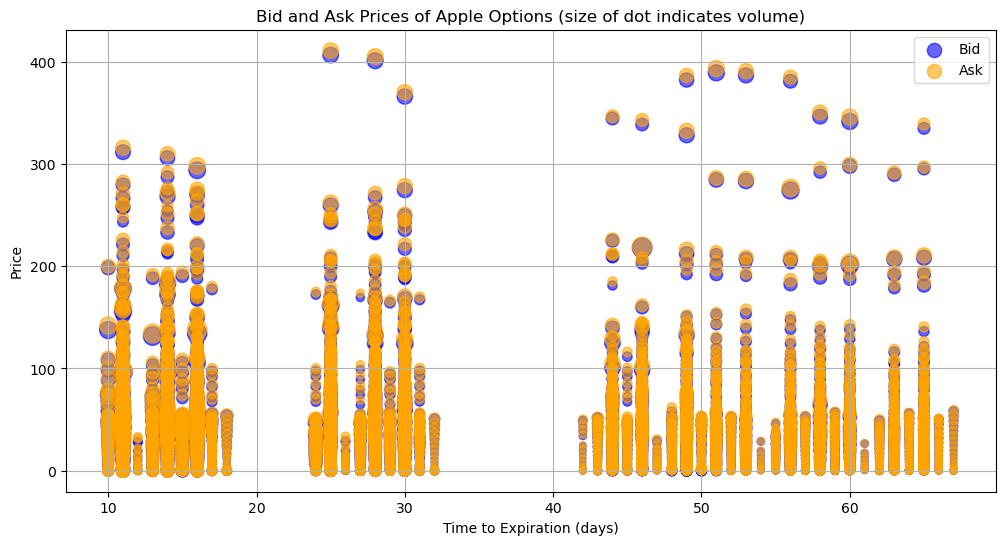

In [13]:
# Normalize volume for marker size (scale between 10 and 200 for better visibility)
df['volume_size'] = np.interp(df['vol'], (df['vol'].min(), df['vol'].max()), (10, 200))

# Filter data for call options (optional)
filtered_df = df[df['call_put'] == 'Call']

# Plot Bid and Ask with marker size based on volume
plt.figure(figsize=(12, 6))

# Plot Bid prices
plt.scatter(
    filtered_df['time_to_expiration'], 
    filtered_df['bid'], 
    s=filtered_df['volume_size'],  # Marker size by volume
    alpha=0.6, 
    color='blue', 
    label='Bid'
)

# Plot Ask prices
plt.scatter(
    filtered_df['time_to_expiration'], 
    filtered_df['ask'], 
    s=filtered_df['volume_size'],  # Marker size by volume
    alpha=0.6, 
    color='orange', 
    label='Ask'
)

# Add labels, title, legend, and grid
plt.xlabel('Time to Expiration (days)')
plt.ylabel('Price')
plt.title('Bid and Ask Prices of Apple Options (size of dot indicates volume)')
plt.legend()
plt.grid()
plt.show()
